# Statistical Learning and Data Mining Project 2020

# Part 1. Forex Classification Problem

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import datetime
import numpy as np
import pandas as pd
import mplfinance
import seaborn as sns
from IPython.core.display import display
from functools import reduce
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab
from pandas_datareader import data

In [3]:
#Keras imports
import keras.backend as K
import keras as keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

Using TensorFlow backend.


## Collecting Data on US Market

In [4]:
#Collect data on S&P500
start_date = '2010-01-01'
end_date = '2020-03-31'

# User pandas_reader.data.DataReader to load the desired data. 
sp = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
sp.index.names=["DATE"]
sp["SP_Ret"] = sp['Close'].pct_change()*100
sp=sp[["SP_Ret"]]

In [5]:
vix = data.DataReader("VIXCLS", "fred", start_date, end_date)

In [6]:
#treasuries 3 and 6 months secondary market rates, 1 year and 10 year secondary market rates
tr_3 = data.DataReader('DTB3', 'fred', start_date, end_date)
tr_6=data.DataReader('DTB6', 'fred', start_date, end_date)
tr_1y = data.DataReader('DTB1YR', 'fred', start_date, end_date)
tr_10y=data.DataReader('DGS10', 'fred', start_date, end_date)
fedfunds = data.DataReader('DFF', 'fred', start_date, end_date)

In [7]:
data_frames = [tr_3, tr_6, tr_1y, tr_10y, fedfunds, sp, vix]
us_market_merged = pd.concat(data_frames, join='outer', axis=1).fillna(method='ffill')

In [8]:
#Bond index + high yield bond index+ economic surprise index
us_bond=pd.read_csv("bond indices.csv")
us_bond.DATE=pd.to_datetime(us_bond.DATE, format='%m/%d/%y', errors='ignore')
us_bond.set_index('DATE', inplace=True)
us_bond.US_Corp_Bonds = us_bond['US_Corp_Bonds'].pct_change()*100
us_bond.GL_HY_Bonds = us_bond['GL_HY_Bonds'].pct_change()*100

In [9]:
surprise=pd.read_csv("economic surprise index.csv")
surprise.DATE=pd.to_datetime(surprise.DATE, format='%m/%d/%y', errors='ignore')
surprise.set_index('DATE', inplace=True)

In [10]:
#Merge data on american market (here just merge close price)
# create dataframe with returns (separate)
data_frames = [us_market_merged, us_bond, surprise]
us_market = pd.concat(data_frames, join='outer', axis=1).fillna(method='ffill')
us_market.head(5)

,DTB3,DTB6,DTB1YR,DGS10,DFF,SP_Ret,VIXCLS,US_Corp_Bonds,GL_HY_Bonds,Ec_Surprise
DATE,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN
2010-01-04,0.08,0.18,0.41,3.85,0.12,NaN,20.04,0.133737,0.487718,NaN
2010-01-05,0.07,0.17,0.37,3.77,0.12,0.311568,19.35,0.440871,0.459149,NaN


In [11]:
len(us_market)

3743

## Collecting Data on European Market

In [12]:
eur_index = data.DataReader('^STOXX', 'yahoo', start_date, end_date)
eur_index.index.names=["DATE"]
eur_index["Eur_Index_Ret"] = eur_index['Close'].pct_change()*100
eur_index=eur_index[["Eur_Index_Ret"]]

In [13]:
#European Interest Rates 
eur_rates=pd.read_csv("eur rates.csv")

In [14]:
#Europen Bond Index
eur_bond=pd.read_csv("european bond index.csv")
eur_bond.DATE=pd.to_datetime(eur_bond.DATE, format='%m/%d/%y')
eur_bond.set_index('DATE', inplace=True)
eur_bond.EUR_Corp_Bonds = eur_bond['EUR_Corp_Bonds'].pct_change()*100

In [15]:
#Merge european data (one for prices one for return)
dfs = [eur_index, eur_bond]
eur_market=pd.concat(dfs, join='outer', axis=1).fillna(method='ffill')

In [16]:
#Merge all the data
dfs=[us_market, eur_market]
market_data=pd.concat(dfs, join='outer', axis=1).fillna(method='ffill')
market_data.head(5)

,DTB3,DTB6,DTB1YR,DGS10,DFF,SP_Ret,VIXCLS,US_Corp_Bonds,GL_HY_Bonds,Ec_Surprise,Eur_Index_Ret,EUR_Corp_Bonds,EUR_3M,EUR_6M,EUR_2Y,EUR_10Y
DATE,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459,0.546,1.332,3.387
2010-01-02,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459,0.546,1.332,3.387
2010-01-03,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459,0.546,1.332,3.387
2010-01-04,0.08,0.18,0.41,3.85,0.12,NaN,20.04,0.133737,0.487718,NaN,NaN,NaN,0.446,0.527,1.347,3.391
2010-01-05,0.07,0.17,0.37,3.77,0.12,0.311568,19.35,0.440871,0.459149,NaN,-0.023286,0.236428,0.442,0.508,1.286,3.373


## Create features

In [17]:
eur_usd=pd.read_csv("eurusd.csv")
eur_usd.DATE=pd.to_datetime(eur_usd.DATE, format='%m/%d/%y')
eur_usd.set_index('DATE', inplace=True)

In [18]:
#Create signal on EURUSD on the last price
#Signal_t variable which we set to 1 if the EURUSD was higher tomorrow than today
eur_usd["Delta_Close"]=eur_usd["Last Price"].diff()
eur_usd["Signal_x"]=(eur_usd['Delta_Close'] > 0).astype(int)
eur_usd["Signal"] = eur_usd["Signal_x"].shift(-1)

In [19]:
#Create features on price
#df['momentum']  = df['volume'] * (df['open'] - df['close'])
eur_usd['Avg_price'] = (eur_usd['Low Price'] + eur_usd['High Price'])/2
eur_usd['Range']     = eur_usd['High Price'] - eur_usd['Low Price']
eur_usd['OHLC_price'] = (eur_usd['Low Price'] + eur_usd['High Price'] + eur_usd['Open Price'] + eur_usd['Last Price'])/4
eur_usd['OC_diff']    = eur_usd['Open Price'] - eur_usd['Last Price']
eur_usd['Spread']= eur_usd['Ask Price'] - eur_usd['Bid Price']

In [20]:
eur_usd=eur_usd[["Last Price","Avg_price", "Range", "OHLC_price", "OC_diff","Spread", "Delta_Close", "Signal", "Signal_x"]]

In [21]:
#merge all data
dfs=[market_data, eur_usd]
data=pd.concat(dfs, join='outer', axis=1).fillna(method='ffill')
data['Last_Lead']=data['Last Price'].shift(-1)
print(len(data))
print(data["Signal"].isna().sum())

3744
0


In [22]:
data.interpolate(method ='linear', limit_direction ='forward') 
data.head(5)

,DTB3,DTB6,DTB1YR,DGS10,DFF,SP_Ret,VIXCLS,US_Corp_Bonds,GL_HY_Bonds,Ec_Surprise,...,Last Price,Avg_price,Range,OHLC_price,OC_diff,Spread,Delta_Close,Signal,Signal_x,Last_Lead
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,...,1.4324,1.4334,0.0042,1.432825,-0.0003,0.0003,NaN,1.0,0.0,1.4324
2010-01-02,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,...,1.4324,1.4334,0.0042,1.432825,-0.0003,0.0003,NaN,1.0,0.0,1.4324
2010-01-03,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,...,1.4324,1.4334,0.0042,1.432825,-0.0003,0.0003,NaN,1.0,0.0,1.4413
2010-01-04,0.08,0.18,0.41,3.85,0.12,NaN,20.04,0.133737,0.487718,NaN,...,1.4413,1.4357,0.0198,1.435975,-0.0101,0.0002,0.0089,0.0,1.0,1.4365
2010-01-05,0.07,0.17,0.37,3.77,0.12,0.311568,19.35,0.440871,0.459149,NaN,...,1.4365,1.4415,0.0138,1.440200,0.0048,0.0004,-0.0048,1.0,0.0,1.4408


## Summary Statistics of Data

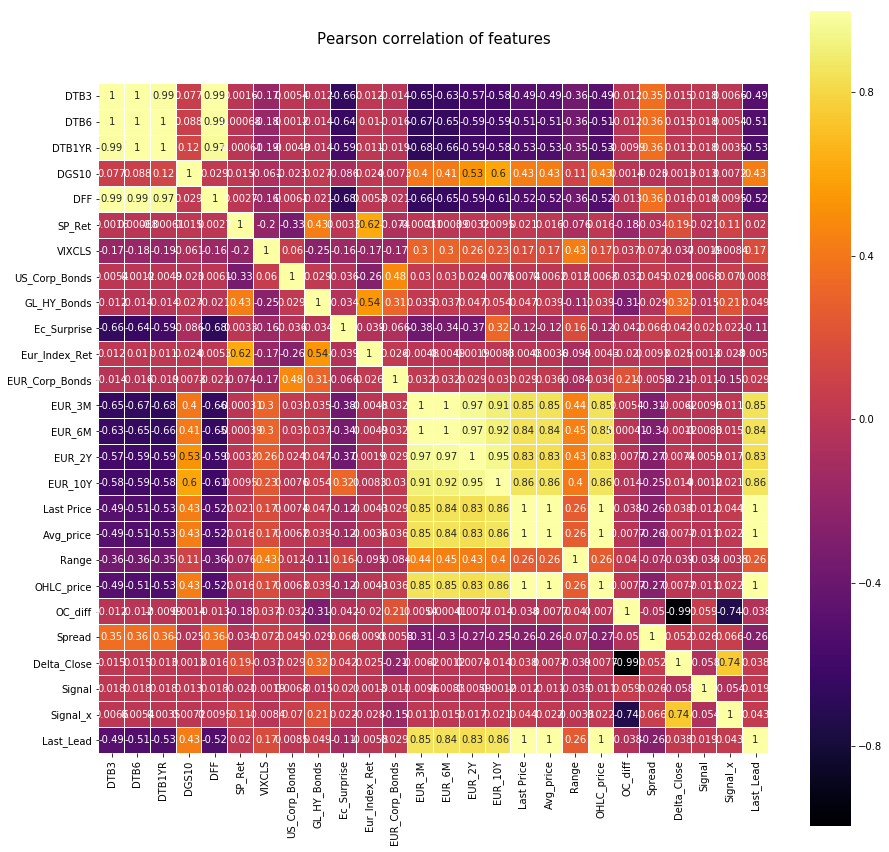

In [23]:
#Pearson Correlation of Features
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(data.corr(), linewidths=0.05, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [24]:
data.describe()

,DTB3,DTB6,DTB1YR,DGS10,DFF,SP_Ret,VIXCLS,US_Corp_Bonds,GL_HY_Bonds,Ec_Surprise,...,Last Price,Avg_price,Range,OHLC_price,OC_diff,Spread,Delta_Close,Signal,Signal_x,Last_Lead
count,3741.000000,3741.000000,3741.000000,3741.000000,3744.000000,3740.000000,3741.000000,3741.000000,3741.000000,1365.000000,...,3744.000000,3744.000000,3744.000000,3744.000000,3744.000000,3744.000000,3741.000000,3744.000000,3744.000000,3743.000000
mean,0.578455,0.649310,0.727191,2.377904,0.628884,0.034895,17.145429,0.019084,0.021780,1.500205,...,1.227873,1.227878,0.010324,1.227900,0.000097,0.000373,-0.000130,0.501603,0.496795,1.227818
std,0.778749,0.786691,0.782786,0.572002,0.760920,1.049977,6.854742,0.216373,0.286560,20.603701,...,0.113775,0.113578,0.005549,0.113634,0.006944,0.000508,0.006945,0.500064,0.500057,0.113741
min,-0.050000,0.020000,0.070000,0.540000,0.040000,-11.984055,9.140000,-2.065371,-3.831060,-32.400000,...,1.038800,1.038500,0.001100,1.039000,-0.032500,0.000000,-0.031400,0.000000,0.000000,1.038800
25%,0.040000,0.090000,0.160000,1.930000,0.110000,-0.329311,12.980000,-0.098932,-0.079640,-14.400000,...,1.121075,1.121625,0.006400,1.121525,-0.003700,0.000100,-0.004100,0.000000,0.000000,1.121050
50%,0.130000,0.190000,0.290000,2.330000,0.170000,0.069501,15.450000,0.020107,0.033431,-2.500000,...,1.224900,1.225325,0.009100,1.225250,0.000000,0.000200,0.000000,1.000000,0.000000,1.224900
75%,1.020000,1.110000,1.200000,2.750000,1.160000,0.494561,18.890000,0.143695,0.150153,17.500000,...,1.330800,1.330162,0.012900,1.330750,0.004100,0.000400,0.003700,1.000000,1.000000,1.330700
max,2.430000,2.510000,2.650000,4.010000,2.450000,9.382774,82.690000,1.031787,2.868465,47.100000,...,1.483000,1.485750,0.051500,1.484200,0.031400,0.005700,0.032500,1.000000,1.000000,1.483000


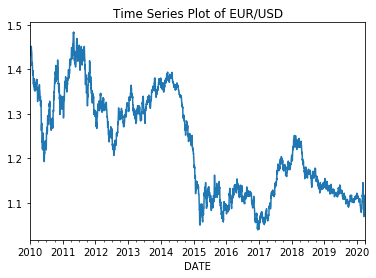

In [25]:
data["Last Price"].plot()
plt.title("Time Series Plot of EUR/USD")
plt.show()

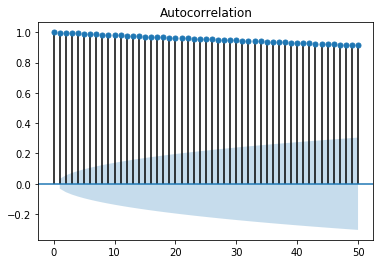

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data["Last Price"], lags=50)
plt.show()
#VERY strong autocorrelation (what to do with that)

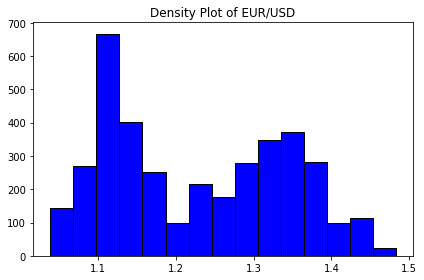

In [27]:
#distribution does not look like normal at all (bimodal)
plt.hist(data["Last Price"], bins = 15, color = 'blue', edgecolor = 'black')
plt.title("Density Plot of EUR/USD")
plt.tight_layout()
plt.show()

Construct X and Y

In [28]:
X=data[['DTB3', 'DTB6', 'DTB1YR', 'DGS10', 'DFF', 'SP_Ret', 'VIXCLS',
       'US_Corp_Bonds', 'GL_HY_Bonds', 'Eur_Index_Ret',
       'EUR_Corp_Bonds', 'EUR_3M', 'EUR_6M', 'EUR_2Y', 'EUR_10Y', 'Last Price',
       'Avg_price', 'Range', 'OHLC_price', 'OC_diff', 'Spread']]
X_s=data['Signal_x']

X=X.fillna(X.mean())

In [29]:
#Add PCA feature to the dataset
from sklearn.decomposition import PCA

dataset = X.copy().values.astype('float32')
pca_features = X.columns.tolist()

pca = PCA(n_components=1)
pca.fit_transform(X)
pca.n_components_

pca_df=pd.DataFrame(pca.fit_transform(X), index=X.index)
X=pd.concat([X,pca_df], join='outer', axis=1,)

In [30]:
Y_signal=data[["Signal"]]
Y_cont=data[["Last_Lead"]]
Y_cont=Y_cont.fillna(Y_cont.mean())

In [31]:
def suffixed_columns(df, suffix):
    return ["{}{}".format(column, suffix) for column in df.columns]

def lag(df, n):
    new_df = df.shift(n)
    new_df.columns = suffixed_columns(df, "_Lag{:02d}".format(n))
    return new_df

X_lag= lag(X,1)
X_lag=X_lag.fillna(X_lag.mean())

Divide Data in training and testing set

In [32]:
print(len(X))
#60% training, 40% testing sets 
x_train, x_test= X.iloc[0:2246,], X.iloc[2246:,]
x_train_lag, x_test_lag=X_lag.iloc[0:2246,], X_lag.iloc[2246:,]
x_s_train, x_s_test=X_s.iloc[0:2246,], X_s.iloc[2246:,]


y_signal_train, y_signal_test=Y_signal.iloc[0:2246,], Y_signal.iloc[2246:,]
y_cont_train, y_cont_test=Y_cont.iloc[0:2246,], Y_cont.iloc[2246:,]
print(len(y_signal_train))

3744
2246


Normalize training and testing sets

In [33]:
x_train_n=(x_train-x_train.mean())/x_train.std()
x_train_n.head(5)

,DTB3,DTB6,DTB1YR,DGS10,DFF,SP_Ret,VIXCLS,US_Corp_Bonds,GL_HY_Bonds,Eur_Index_Ret,...,EUR_6M,EUR_2Y,EUR_10Y,Last Price,Avg_price,Range,OHLC_price,OC_diff,Spread,0
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-01,8.034455,5.814734,4.588231,-0.131882,-1.414456,0.000323,-0.196668,-0.004564,-0.007778,-0.002583,...,0.881374,1.891106,1.969586,1.389079,1.403088,-1.357011,1.396286,-0.063344,0.562031,-0.183829
2010-01-02,8.034455,5.814734,4.588231,-0.131882,-1.414456,0.000323,-0.196668,-0.004564,-0.007778,-0.002583,...,0.881374,1.891106,1.969586,1.389079,1.403088,-1.357011,1.396286,-0.063344,0.562031,-0.183829
2010-01-03,8.034455,5.814734,4.588231,-0.131882,-1.414456,0.000323,-0.196668,-0.004564,-0.007778,-0.002583,...,0.881374,1.891106,1.969586,1.389079,1.403088,-1.357011,1.396286,-0.063344,0.562031,-0.183829
2010-01-04,0.083623,0.551377,1.801159,2.362353,-0.182839,0.000323,0.282712,0.532447,1.771441,-0.002583,...,0.831125,1.918663,1.974241,1.476327,1.425697,1.372577,1.427241,-1.301021,0.002739,0.295819
2010-01-05,-0.075887,0.439226,1.449689,2.226806,-0.182839,0.280692,0.168439,1.971008,1.662350,-0.036382,...,0.780876,1.806595,1.953293,1.429272,1.482712,0.322735,1.468759,0.580754,1.121322,0.180666


In [34]:
x_test_n=(x_test-x_test.mean())/x_test.std()

Convert to numpy arrays

In [35]:
#features
x_train=np.array(x_train_n)
x_test=np.array(x_test_n)

#outcomes
y_signal_train=np.array(y_signal_train)
y_signal_test=np.array(y_signal_test)
y_cont_train=np.array(y_cont_train)
y_cont_test=np.array(y_cont_test)

In [36]:
len(y_signal_train)
len(y_signal_test)

1498

Baseline

In [37]:
(y_signal_test==1).sum()/len(y_signal_test)

0.5153538050734312

In [38]:
(y_signal_train==1).sum()/len(y_signal_train)

0.4924309884238646

## Logistic regression, Ridge and Lasso For Classification

Logistic Regression

In [39]:
lr = LogisticRegression(C=1e3, class_weight='balanced')
lr.fit(x_train, y_signal_train)
print(accuracy_score(y_signal_train, lr.predict(x_train)))
lr_preds = lr.predict(x_test)
print(accuracy_score(y_signal_test, lr_preds))

0.5676758682101514
0.5106809078771696


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Forest Classifier

In [40]:
#55% accuracy
rf = RandomForestClassifier(
    n_estimators=32, 
    max_depth=5, 
    min_samples_leaf=2, 
    n_jobs=3, 
    random_state=124, 
    class_weight='balanced'
)
rf.fit(x_train, y_signal_train)

print(accuracy_score(y_signal_train, rf.predict(x_train))) #gets the highest in sample accuracy
print(accuracy_score(y_signal_test, rf.predict(x_test)))

#try tuning the model to get better results

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.7853962600178095
0.5487316421895861


In [41]:
tn, fp, fn, tp = confusion_matrix(y_signal_test, rf.predict(x_test)).ravel()
tn

367

In [42]:
#Tuning Random Forest Model

def Snippet_146():
    print()

    import warnings
    warnings.filterwarnings("ignore")

    from sklearn import decomposition, datasets
    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from sklearn.preprocessing import StandardScaler
    
    xtrain = x_train
    ytrain = y_signal_train

    rf = RandomForestClassifier()

    pipe = Pipeline(steps=[('rf', rf)])

    # Create Parameter Space
    # Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,x_train.shape[1]+1,1))

    # Create lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    n_estimators=[20,30,32,40]
    max_depth = [5,8,12,16]
    min_samples_leaf = [3,5,7]
    n_jobs=[3,5]
    
    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(rf__criterion=criterion,
                      rf__n_estimators=n_estimators,
                      rf__max_depth=max_depth,
                      rf__min_samples_leaf = min_samples_leaf,
                      rf__n_jobs=n_jobs
                     )

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(xtrain, ytrain)

    # View The Best Parameters
    print('Best Criterion:', clf.best_estimator_.get_params()['rf__criterion'])
    print('Best number of estimators:', clf.best_estimator_.get_params()['rf__n_estimators'])
    print('Best max_depth:', clf.best_estimator_.get_params()['rf__max_depth'])
    print('Best min_samples_leaf:', clf.best_estimator_.get_params()['rf__min_samples_leaf'])
    print('Best n jobs:', clf.best_estimator_.get_params()['rf__n_jobs'])
    print(); print(clf.best_estimator_.get_params()['rf'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, xtrain, ytrain, cv=4, n_jobs=-1)
    print('CV Result'); print(CV_Result)
    print('CV Result Mean'); print(CV_Result.mean())
    print('CV Result Std'); print(CV_Result.std())

Snippet_146()


Best Criterion: entropy
Best number of estimators: 40
Best max_depth: 16
Best min_samples_leaf: 5
Best n jobs: 5

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=5,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV Result
[0.52135231 0.53736655 0.47593583 0.51158645]
CV Result Mean
0.5115602857124734
CV Result Std
0.022533029016693802


In [43]:
#Run the best random forest model
rf = RandomForestClassifier(
    criterion="entropy",
    n_estimators=20, 
    max_depth=5, 
    min_samples_leaf=3, 
    n_jobs=5, 
    random_state=123, 
    class_weight='balanced'
)
rf.fit(x_train, y_signal_train)

print(accuracy_score(y_signal_train, rf.predict(x_train)))
print(accuracy_score(y_signal_test, rf.predict(x_test)))

0.7337488869100623
0.534712950600801


In [44]:
confusion_matrix(y_signal_test, rf.predict(x_test))

array([[348, 378],
       [319, 453]])

[[348 378]
 [319 453]]


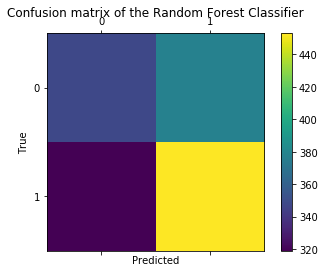

In [45]:
labels = [0,1]
cm = confusion_matrix(y_signal_test, rf.predict(x_test), labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Random Forest Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
y_signal_test

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [47]:
#Find the importance of the features in the random forest model
feature_importance = rf.feature_importances_
std = np.std([rf.feature_importances_ for forest in rf.estimators_], axis=0)
i = np.argsort(feature_importance)[::-1]

feature_names = X.columns.tolist()
print("Feature ranking:")
for feature in range(x_train.shape[1]-1):
    print ("%d. %s %d (%f)" % (feature,feature_names[i[feature]], i[feature], feature_importance[i[feature]]))

Feature ranking:
0. Eur_Index_Ret 9 (0.079342)
1. Range 17 (0.071547)
2. EUR_2Y 13 (0.069523)
3. DGS10 3 (0.065776)
4. OC_diff 19 (0.063056)
5. VIXCLS 6 (0.056631)
6. EUR_Corp_Bonds 10 (0.054122)
7. SP_Ret 5 (0.052189)
8. Spread 20 (0.052014)
9. Last Price 15 (0.049874)
10. DFF 4 (0.046016)
11. US_Corp_Bonds 7 (0.044054)
12. 0 21 (0.043085)
13. DTB3 0 (0.038794)
14. GL_HY_Bonds 8 (0.034727)
15. DTB1YR 2 (0.034140)
16. EUR_3M 11 (0.031684)
17. DTB6 1 (0.030308)
18. EUR_6M 12 (0.028022)
19. OHLC_price 18 (0.022826)
20. Avg_price 16 (0.017422)


SVM

In [48]:
from sklearn import svm
SVM = svm.SVC(kernel="sigmoid", C = 1000, gamma= 0.0001, class_weight='balanced')
SVM.fit(x_train, y_signal_train)
accuracy_score(y_signal_test, SVM.predict(x_test))

0.49666221628838453

Gradient Boosting Classifier

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,200], 
            'learning_rate': [0.001,0.01,0.1],
            'max_depth':[4,7], 
            'max_features':[1,3,'sqrt']} 
gbc=GradientBoostingClassifier()
grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_signal_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   31.8s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [4, 7], 'max_features': [1, 3, 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [50]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [51]:
print(accuracy_score(y_signal_train, grid_search.predict(x_train)))
print(accuracy_score(y_signal_test, grid_search.predict(x_test)))

1.0
0.5006675567423231


Ridge Classifier

In [52]:
#Ridge Regression Cross Validation
#Since we have time series data we perform time series cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
alphas=np.logspace(-4, -0.5, 30)
avg_acc=[]

  
for i in alphas:
    acc=[]
    for train_index, test_index in tscv.split(x_train):
        x_tr, x_t = x_train[train_index], x_train[test_index]
        y_tr, y_t =y_signal_train[train_index], y_signal_train[test_index]
        ridge = RidgeClassifier(alpha=i)
        ridge.fit(x_tr,y_tr)
        acc.append(accuracy_score(y_t,ridge.predict(x_t)))    
    avg_acc.append(np.mean(np.array(acc)))

In [53]:
avg_acc=np.array(avg_acc)
np.argwhere(avg_acc==max(avg_acc))
alphas[np.argwhere(avg_acc==max(avg_acc))]
#choose the lowest alpha (however, does not make a lot of difference in and put of sample)

array([[0.01487352],
       [0.01963828],
       [0.02592944],
       [0.03423598]])

In [54]:
ridge = RidgeClassifier(alpha=0.01487352)
ridge.fit(x_train, y_signal_train)
print(accuracy_score(y_signal_train, ridge.predict(x_train)))
print(accuracy_score(y_signal_test, ridge.predict(x_test)))

0.5650044523597507
0.5020026702269693


Neural Nets

In [55]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_signal_train)
y_signal_train=enc.transform(y_signal_train).toarray()
print(y_signal_train.shape)

(2246, 2)


In [56]:
from keras.layers import Dense, Softmax, Dropout
K.clear_session()

num_classes = 2
num_hidden_units = 256
digit_input = Input(shape=(x_train.shape[1],))
x = Dense(num_hidden_units, activation='relu')(digit_input)
y=Dropout(0.2)(x)
x1= Dense(256, activation='relu')(y)
y1=Dropout(0.2)(x1)
x2= Dense(num_hidden_units, activation='relu')(y1)
output = Dense(num_classes, activation='sigmoid')(x2)
model = Model(digit_input, output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model.fit(
    x_train, y_signal_train, 
    batch_size=32, 
    epochs=200, 
    shuffle=False, 
    validation_split=0.2,
    verbose=False
)

In [58]:
keras_nn_preds = np.argmax(model.predict(x_test), axis=1)
print('accuracy {:.2f}\nf1 micro score {:.2f}'.format(
    accuracy_score(y_signal_test, keras_nn_preds), 
    f1_score(y_signal_test, keras_nn_preds, average='micro'))
     )
pd.DataFrame(
    confusion_matrix(y_signal_test, keras_nn_preds)
).rename_axis('True Label').rename_axis('Predicted Label', axis=1)

accuracy 0.48
f1 micro score 0.48


Predicted Label,0,1
True Label,,
0,332,394
1,381,391


In [59]:
k=np.argmax(model.predict(x_train), axis=1)

## Create the trading strategy using the binary prediction

In [60]:
#Here we are going to use the best model to create the trading strategy based on the predicted signal
#Random Forest was the best model, hence, we use is for predictions
#So predictions for Logistic Regression as the base case
#use Grdient Boosting Classifier as the second best performing model

In [61]:
#We start with enough cash in USD to buy a unit of EUR.
#if signal=1, long EURUSD, if signal=0 then short EURUSD

Cumulative Returns for the Testing Set

In [62]:
#logistic regression
log_pred=lr.predict(x_test)

#Random Forest
rf_pred=rf.predict(x_test)

#GBC
gbc_pred=grid_search.predict(x_test)

#SVM
svm_pred=SVM.predict(x_test)

#Ridge
ridge_pred=ridge.predict(x_test)

#NN
nn_pred=keras_nn_preds

In [63]:
x_train, x_test= X.iloc[0:2246,], X.iloc[2246:,]

In [64]:
X_test=pd.DataFrame(x_test)
X_test.columns=X.columns

In [65]:
X_test["log_pred"]=log_pred
X_test["rf_pred"]=rf_pred
X_test["gbc_pred"]=gbc_pred
X_test["svm_pred"]=svm_pred
X_test["ridge_pred"]=ridge_pred
X_test["nn_pred"]=nn_pred
X_test["base"]=-1

In [66]:
X_test["log_pred"]=X_test["log_pred"].shift(1)
X_test["rf_pred"]=X_test["rf_pred"].shift(1)
X_test["gbc_pred"]=X_test["gbc_pred"].shift(1)
X_test["svm_pred"]=X_test["svm_pred"].shift(1)
X_test["ridge_pred"]=X_test["ridge_pred"].shift(1)
X_test["nn_pred"]=X_test["nn_pred"].shift(1)
X_test["base"]=X_test["base"].shift(1)

In [67]:
X_test=X_test.iloc[:,22:29]
X_test=X_test.replace(0, -1)

In [68]:
close_price=data["Last Price"]
close_price=close_price[2246:]
close_price=np.array(close_price)

In [69]:
X_test["close"]=np.array(close_price)

In [70]:
X_test["return"] = X_test["close"].pct_change(1)

In [71]:
X_test["log_ret"]=X_test["return"]*X_test["log_pred"]
X_test["rf_ret"]=X_test["return"]*X_test["rf_pred"]
X_test["gbc_ret"]=X_test["return"]*X_test["gbc_pred"]
X_test["svm_ret"]=X_test["return"]*X_test["svm_pred"]
X_test["ridge_ret"]=X_test["return"]*X_test["ridge_pred"]
X_test["nn_ret"]=X_test["return"]*X_test["nn_pred"]
X_test["base_ret"]=X_test["return"]*X_test["base"]

In [72]:
X_test.head(5)

,log_pred,rf_pred,gbc_pred,svm_pred,ridge_pred,nn_pred,base,close,return,log_ret,rf_ret,gbc_ret,svm_ret,ridge_ret,nn_ret,base_ret
DATE,,,,,,,,,,,,,,,,
2016-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-26,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0934,-0.007624,-0.007624,0.007624,-0.007624,-0.007624,-0.007624,0.007624,0.007624
2016-02-27,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
2016-02-28,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
2016-02-29,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0873,-0.005579,-0.005579,-0.005579,-0.005579,-0.005579,-0.005579,-0.005579,0.005579


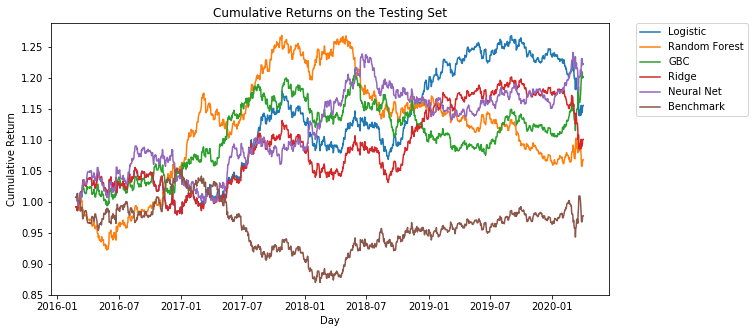

In [73]:
#Cumulative Returns graphs
from matplotlib.pyplot import figure 

log_cum_ret=np.cumprod(1 + X_test['log_ret'])
rf_cum_ret=np.cumprod(1 + X_test['rf_ret'])
gbc_cum_ret=np.cumprod(1 + X_test['gbc_ret'])
svm_cum_ret=np.cumprod(1 + X_test['svm_ret'])
ridge_cum_ret=np.cumprod(1 + X_test['ridge_ret'])
nn_cum_ret=np.cumprod(1 + X_test['nn_ret'])
base_cum_ret=np.cumprod(1 + X_test['base_ret'])

plt.figure(figsize=(10,5))
plt.plot(log_cum_ret, label="Logistic")
plt.plot(rf_cum_ret, label="Random Forest")
plt.plot(gbc_cum_ret, label="GBC")
plt.plot(ridge_cum_ret, label="Ridge")
plt.plot(nn_cum_ret, label="Neural Net")
plt.plot(base_cum_ret, label="Benchmark")
plt.title("Cumulative Returns on the Testing Set")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Cumulative Returns for the Training Set

In [74]:
#logistic regression
log_pred=lr.predict(x_train)

#Random Forest
rf_pred=rf.predict(x_train)

#GBC
gbc_pred=grid_search.predict(x_train)

#SVM
svm_pred=SVM.predict(x_train)

#Ridge
ridge_pred=ridge.predict(x_train)

#NN
nn_pred=np.argmax(model.predict(x_train), axis=1)

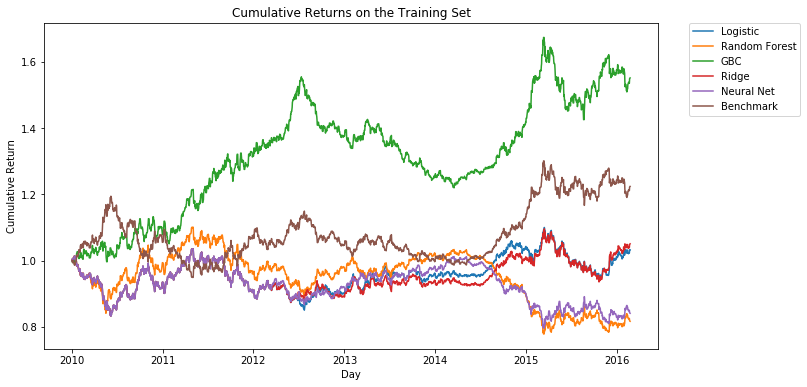

In [75]:
x_train, x_test= X.iloc[0:2246,], X.iloc[2246:,]

X_train=pd.DataFrame(x_train)
X_train.columns=X.columns

X_train["log_pred"]=log_pred
X_train["rf_pred"]=rf_pred
X_train["gbc_pred"]=gbc_pred
X_train["svm_pred"]=svm_pred
X_train["ridge_pred"]=ridge_pred
X_train["nn_pred"]=nn_pred
X_train["base"]=-1

X_train["log_pred"]=X_train["log_pred"].shift(1)
X_train["rf_pred"]=X_train["rf_pred"].shift(1)
X_train["gbc_pred"]=X_train["gbc_pred"].shift(1)
X_train["svm_pred"]=X_train["svm_pred"].shift(1)
X_train["ridge_pred"]=X_train["ridge_pred"].shift(1)
X_train["nn_pred"]=X_train["nn_pred"].shift(1)
X_train["base"]=X_train["base"].shift(1)

X_train=X_train.iloc[:,22:29]
X_train=X_train.replace(0, -1)

close_price=data["Last Price"]
close_price=close_price[:2246]
close_price=np.array(close_price)

X_train["close"]=np.array(close_price)
X_train["return"] = X_train["close"].pct_change(1)

X_train["log_ret"]=X_train["return"]*X_train["log_pred"]
X_train["rf_ret"]=X_train["return"]*X_train["rf_pred"]
X_train["gbc_ret"]=X_train["return"]*X_train["gbc_pred"]
X_train["svm_ret"]=X_train["return"]*X_train["svm_pred"]
X_train["ridge_ret"]=X_train["return"]*X_train["ridge_pred"]
X_train["nn_ret"]=X_train["return"]*X_train["nn_pred"]
X_train["base_ret"]=X_train["return"]*X_train["base"]

#Cumulative Returns graphs
log_cum_ret=np.cumprod(1 + X_train['log_ret'])
rf_cum_ret=np.cumprod(1 + X_train['rf_ret'])
gbc_cum_ret=np.cumprod(1 + X_train['gbc_ret'])
svm_cum_ret=np.cumprod(1 + X_train['svm_ret'])
ridge_cum_ret=np.cumprod(1 + X_train['ridge_ret'])
nn_cum_ret=np.cumprod(1 + X_train['nn_ret'])
base_cum_ret=np.cumprod(1 + X_train['base_ret'])

plt.figure(figsize=(11,6))
plt.plot(log_cum_ret, label="Logistic")
plt.plot(rf_cum_ret, label="Random Forest")
plt.plot(gbc_cum_ret, label="GBC")
plt.plot(ridge_cum_ret, label="Ridge")
plt.plot(nn_cum_ret, label="Neural Net")
plt.plot(base_cum_ret, label="Benchmark")
plt.title("Cumulative Returns on the Training Set")
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Part 2. Prediction of Close Price of EURUSD 15 min in the future

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab
from sklearn.ensemble import RandomForestRegressor
#Used TA-Lib for creating additional features. More on this later.
from talib.abstract import *
from talib import MA_Type

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import keras.backend as K

In [77]:
#process the data
data = pd.read_csv("/Users/nastyademina/Desktop/SL project/EURUSD_15m.csv")
data.rename(columns={'Time' : 'Date'}, inplace=True)
data["Date"]=pd.to_datetime(data["Date"], infer_datetime_format=True)
data.set_index('Date', inplace=True)
data=data.astype(float)
data=data[data.index>="2015-01-01 00:00:00"]

#add additional features
data['Hour'] = data.index.hour
data['Day']  = data.index.weekday
data['Week'] = data.index.week
data['Momentum']  = data['Volume'] * (data['Open'] - data['Close'])
data['Avg_price'] = (data['Low'] + data['High'])/2
data['Range']     = data['High'] - data['Low']
data['Ohlc_price'] = (data['Low'] + data['High'] + data['Open'] + data['Close'])/4
data['Oc_diff']    = data['Open'] - data['Close']

inputs = {
    'open'   : data['Open'].values,
    'high'   : data['High'].values,
    'low'    : data['Low'].values,
    'close'  : data['Close'].values,
    'volume' : data['Volume'].values
}
data['Ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
data['Bear_power'] = data['Low'] - data['Ema']
data['Bull_power'] = data['High'] - data['Ema']
data.dropna(inplace=True)
data.head(5)

,Open,High,Low,Close,Volume,Hour,Day,Week,Momentum,Avg_price,Range,Ohlc_price,Oc_diff,Ema,Bear_power,Bull_power
Date,,,,,,,,,,,,,,,,
2015-01-01 21:00:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 21:15:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 21:30:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 21:45:00,1.20976,1.20976,1.20976,1.20976,0.0,21,3,1,0.000000,1.209760,0.00000,1.209760,0.00000,1.209760,6.661338e-16,6.661338e-16
2015-01-01 22:00:00,1.21038,1.21064,1.21025,1.21035,244299997.3,22,3,1,7328.999919,1.210445,0.00039,1.210405,0.00003,1.209765,4.851685e-04,8.751685e-04


In [78]:
#Add 1D PCA vector as a feature to increase variability!
dataframe = data.copy().values.astype('float32')
pca_features = data.columns.tolist()
pca = PCA(.99)
pca.fit_transform(data)
pca.n_components_ #how many components PCA choose after fitting the model
pca = PCA(n_components=1)
data['pca'] = pca.fit_transform(dataframe) #Fit the model with X and apply the dimensionality reduction on X
print(pca.explained_variance_ratio_)

[0.99999488]


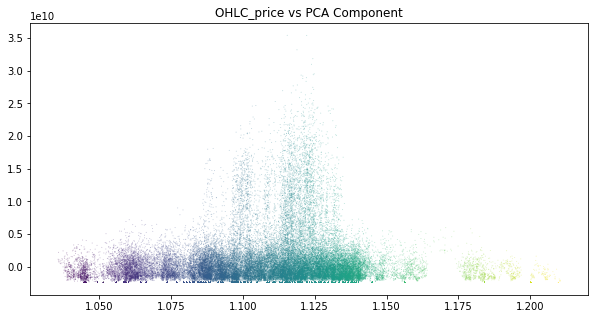

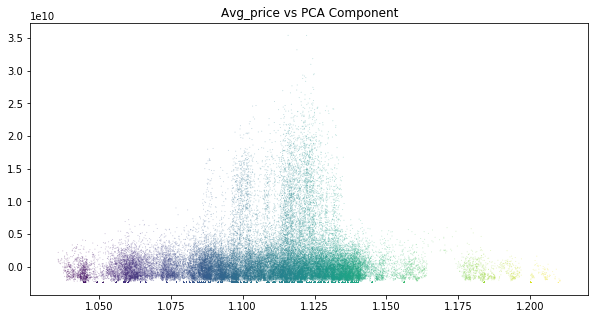

In [79]:
#some scatters of features vs pca component
plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Ohlc_price'].values.min(), data['Ohlc_price'].values.max())
color = cm.viridis(norm(data['Ohlc_price'].values))
plt.scatter(data['Ohlc_price'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('OHLC_price vs PCA Component')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Avg_price'].values.min(), data['Avg_price'].values.max())
color = cm.viridis(norm(data['Avg_price'].values))
plt.scatter(data['Avg_price'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Avg_price vs PCA Component')
plt.show()

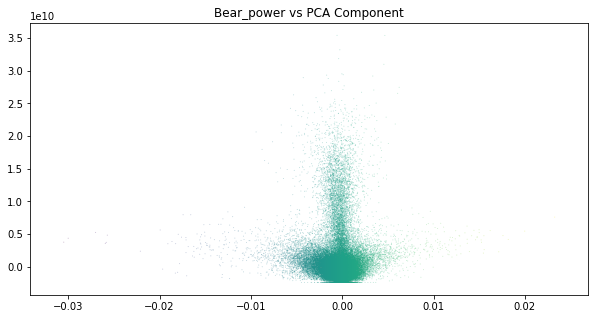

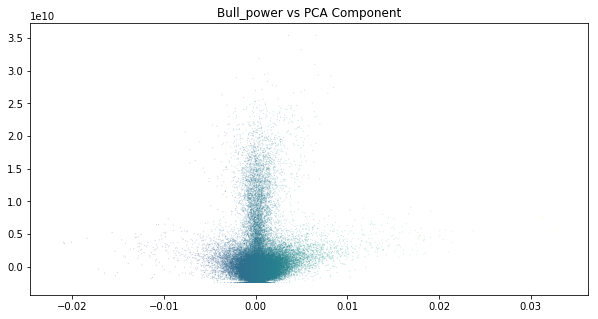

In [80]:
plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Bear_power'].values.min(), data['Bear_power'].values.max())
color = cm.viridis(norm(data['Bear_power'].values))
plt.scatter(data['Bear_power'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Bear_power vs PCA Component')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(data['Bull_power'].values.min(), data['Bull_power'].values.max())
color = cm.viridis(norm(data['Bull_power'].values))
plt.scatter(data['Bull_power'].values, data['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('Bull_power vs PCA Component')
plt.show()

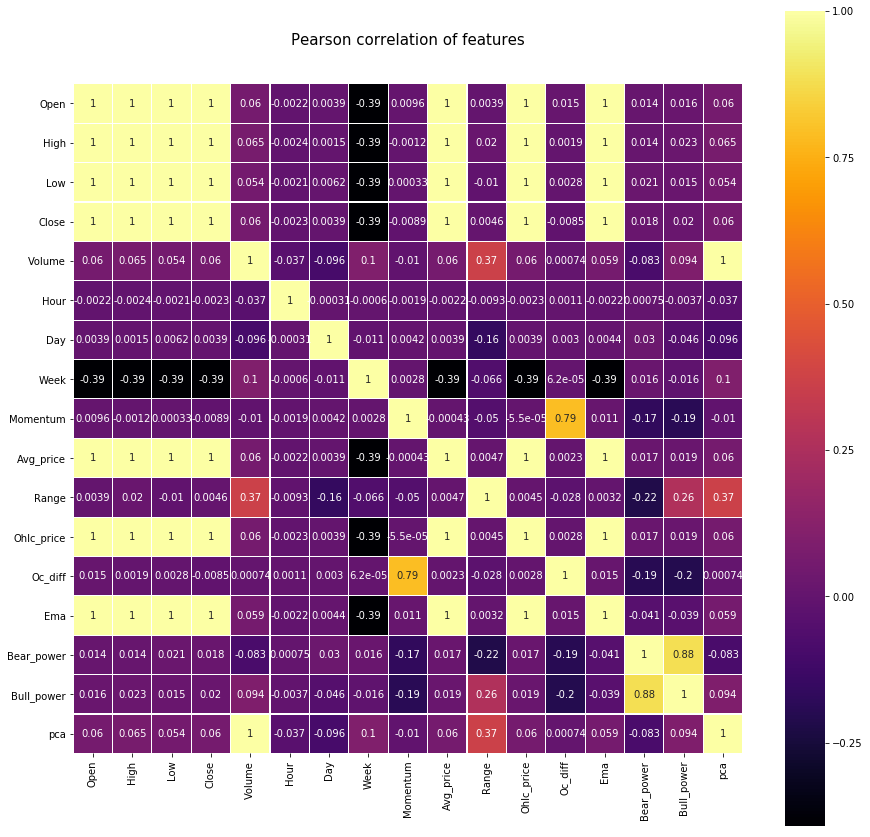

In [81]:
#pearson correation between variables
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(data.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

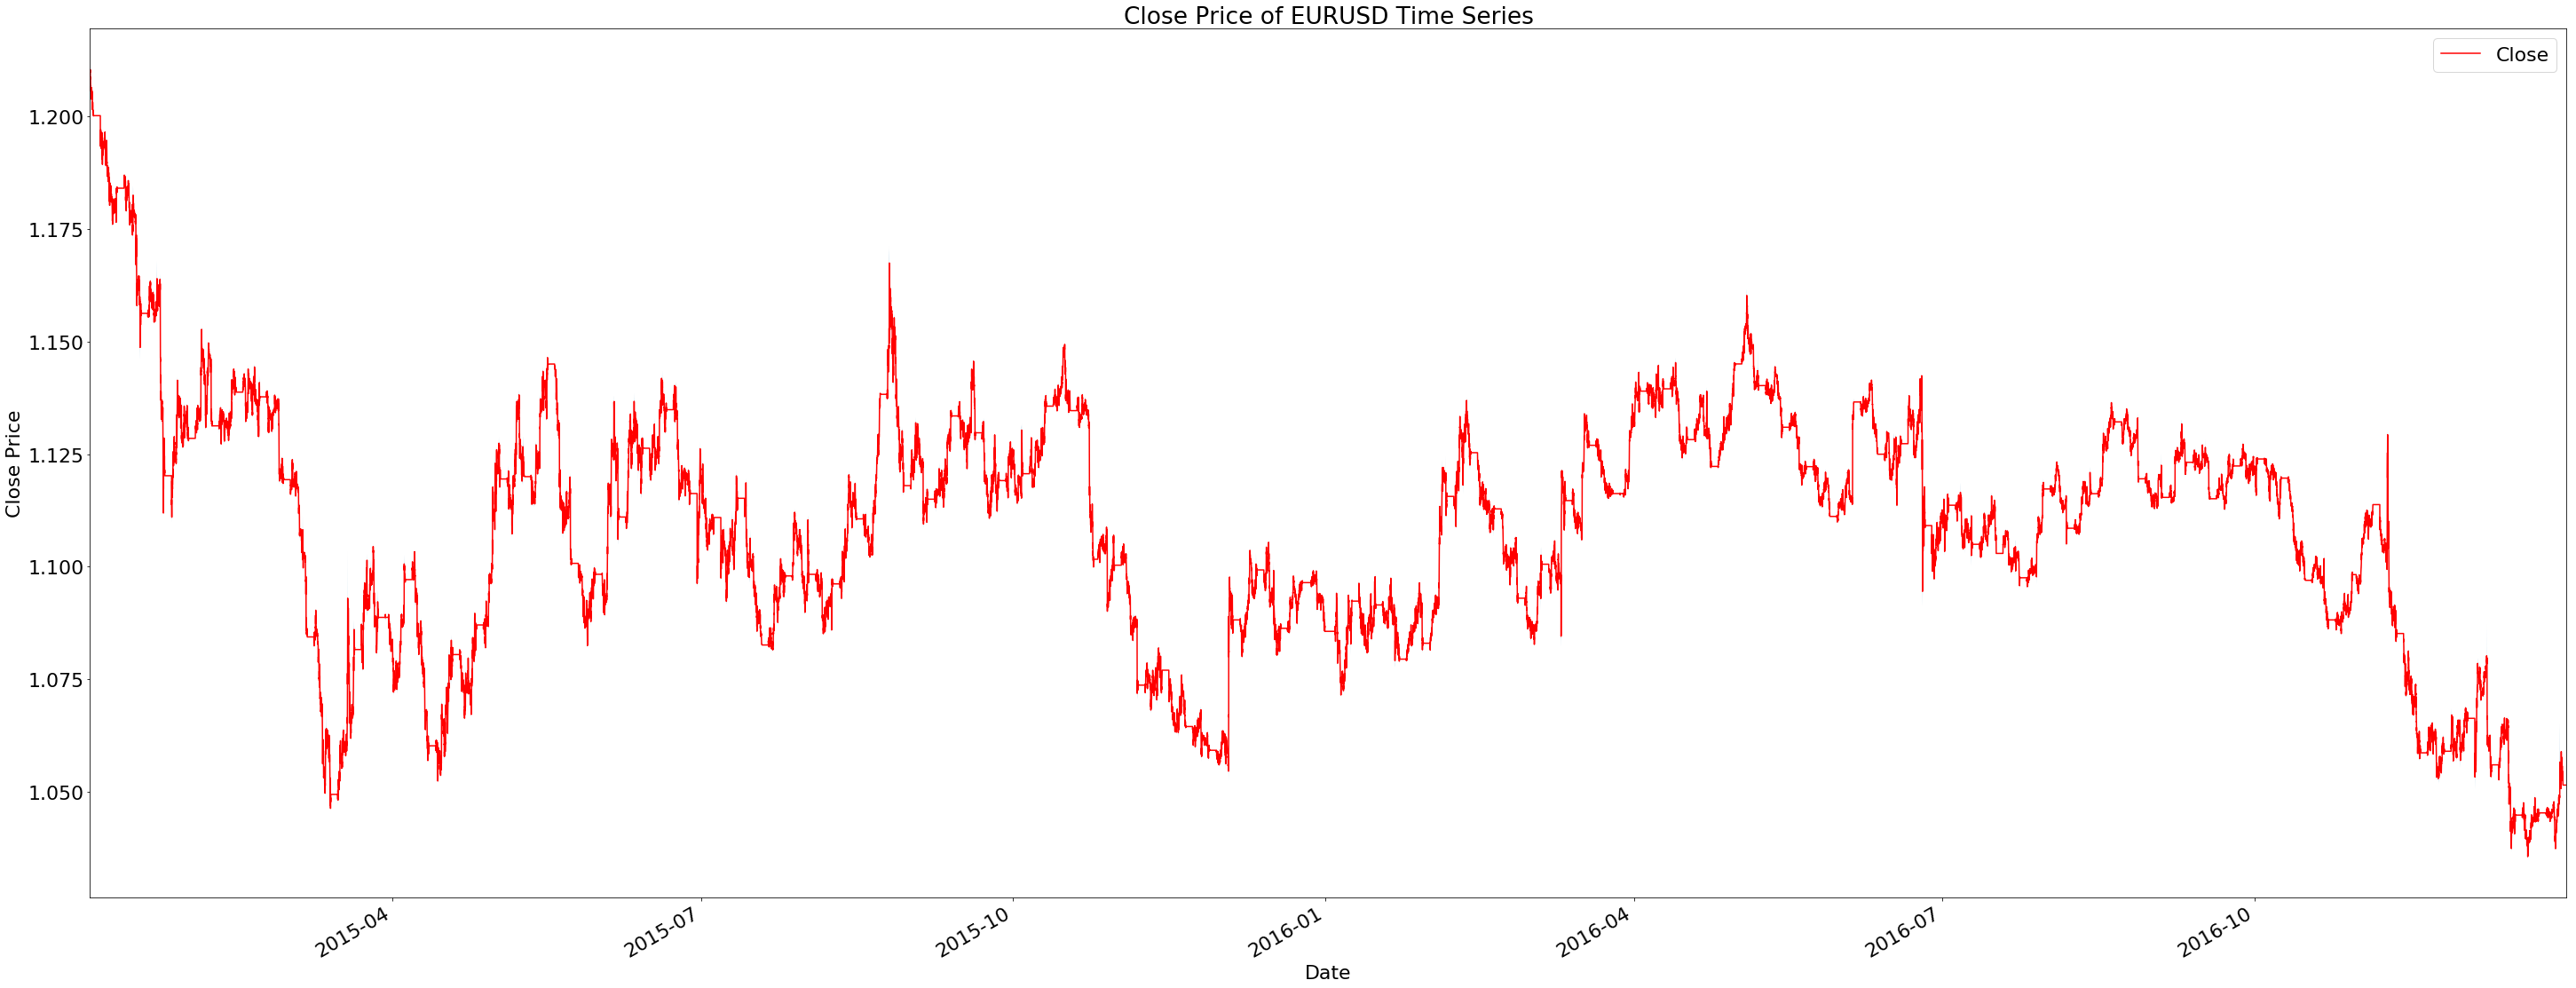

In [82]:
#look at the time series graph of the close price
plt.rcParams.update({'font.size': 22})
ax = data.plot( y='Close', c='red', figsize=(50,20))
i = [str(item) for item in data.index]
plt.fill_between(x=i, y1='Low',y2='High', data=data)
plt.ylabel("Close Price")
plt.title("Close Price of EURUSD Time Series")
plt.show()

### Analysis: Random Forest for Finding the Most Importnat Features

In [83]:
#Define a function that defines the set of the past data (for the past 5 hours)
def make_5h_data(df, lag=20):
    X, Y = [], []
    for i in range(len(df)-lag-1):
        a = df[i:(i+lag)]
        X.append(a)
        Y.append(df[i + lag])
    return np.array(X), np.array(Y)

In [84]:
#Firstly, we scale the data we have using MinMaxScaler function to set values of all features to be between 0 and 1
close_ind = data.columns.tolist().index('Close')
dataframe = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataframe = scaler.fit_transform(dataframe)

#Now we create our variables x (independant) and y (dependent)
x, y = make_5h_data(dataframe, lag=1)
y = y[:,close_ind]
x = np.reshape(x, (x.shape[0], x.shape[2]))

In [85]:
#now we fit random forest to find whart features are important in predicting close price in the next fifteen minutes
rf = RandomForestRegressor(n_estimators = 100)
rf = rf.fit(x, y) #fit random forest on the training set

#Here we rank the fatures by their importance
feature_importance = rf.feature_importances_
std = np.std([rf.feature_importances_ for forest in rf.estimators_], axis=0)
i = np.argsort(feature_importance)[::-1]

feature_names = data.columns.tolist()
print("Feature ranking:")
for feature in range(x.shape[1]-1):
    print ("%d. %s %d (%f)" % (feature, feature_names[i[feature]], i[feature], feature_importance[i[feature]]))

Feature ranking:
0. Close 3 (0.815596)
1. Ohlc_price 11 (0.149345)
2. Avg_price 9 (0.023275)
3. High 1 (0.008187)
4. Low 2 (0.002165)
5. Open 0 (0.000856)
6. Ema 13 (0.000294)
7. Range 10 (0.000042)
8. Bull_power 15 (0.000038)
9. Bear_power 14 (0.000035)
10. Momentum 8 (0.000032)
11. Oc_diff 12 (0.000030)
12. Week 7 (0.000026)
13. Hour 5 (0.000022)
14. pca 16 (0.000021)
15. Volume 4 (0.000021)


In [86]:
#Create DataSet for the Neural Net

#We again scale all of our features no make them between 0 and 1
close_index = data.columns.tolist().index('Close')
high_index = data.columns.tolist().index('High')
low_index = data.columns.tolist().index('Low')
dataframe = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataframe = scaler.fit_transform(dataframe)
scaled_y = MinMaxScaler(feature_range=(0, 1))
yt = data['Close'].values.astype('float32')
yt = np.reshape(yt, (-1, 1))
scaled_y = scaled_y.fit(yt)

#Now we create our variables x (independant) and y (dependent)
#here we can see that we're looking at the past five hours of data since the lag of 20 of 15 min is equal to the 5 hours
x, y = make_5h_data(dataframe, lag=20)
y = y[:,close_index]
print(x.shape) #we can see now that x is three dimensional
print(y.shape)

#Define training and testing sets
#Our dataset is quite large that is why we choose 0.9 as our cutoff for the testing-trainig set split
cutoff = int(len(x) * 0.90)
x_train = x[:cutoff]
y_train = y[:cutoff]
x_test = x[cutoff:]
y_test = y[cutoff:]

(70063, 20, 17)
(70063,)


### LTSM

In [87]:
#create model structure
model = Sequential()
model.add(LSTM(20, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

#look at the model summary to see the layers and all of the parameters
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 20)            3040      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [89]:
#Here we create a check point in the model, which will update the best weights based on the validation error
#validation will be defined in the network fit to be 0.1 (10% of training data will be used as a validation set)
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

#fit the model
ltsm1 = model.fit(x_train, y_train, epochs=200, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

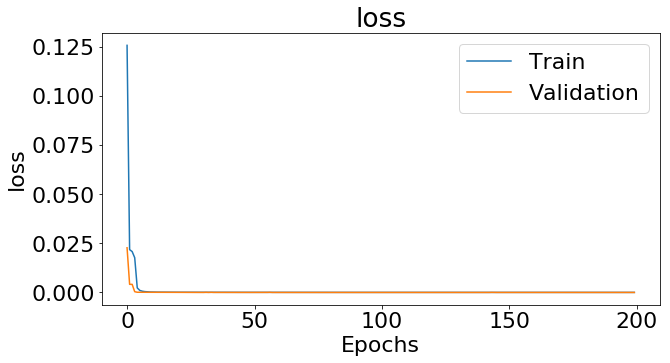

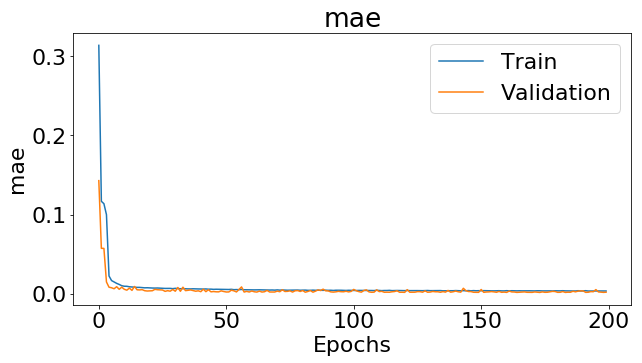

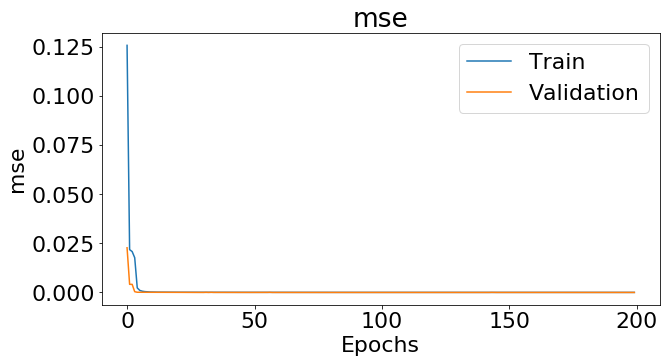

In [90]:
#create graphs to see how the validation error changes while the number of epochs increases
epoch = len(ltsm1.history['loss'])
for k in list(ltsm1.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(10,5))
        plt.plot(ltsm1.history[k])
        plt.plot(ltsm1.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

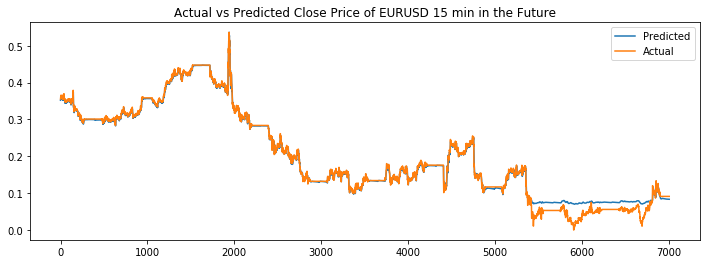

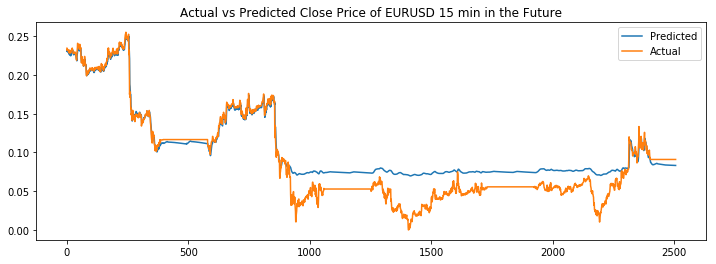

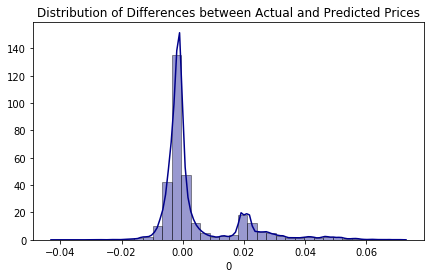

MSE :  0.00018295679
MAE :  0.0076377518


,0
count,7007.000000
mean,0.003968
std,0.012932
min,-0.040841
25%,-0.002679
50%,-0.001057
75%,0.003016
max,0.070826


In [145]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# graph of actual vs predicted price by the model
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,4))
plt.plot(model.predict(x_test))
plt.plot(y_test)
plt.title("Actual vs Predicted Close Price of EURUSD 15 min in the Future")
plt.legend(['Predicted', 'Actual'], loc='upper right')
plt.show()

# graph of actual vs predicted price by the model
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,4))
plt.plot(model.predict(x_test)[4500:])
plt.plot(y_test[4500:])
plt.title("Actual vs Predicted Close Price of EURUSD 15 min in the Future")
plt.legend(['Predicted', 'Actual'], loc='upper right')
plt.show()

#histogram of the differences between actual and predicted close prices
diff = pd.DataFrame(model.predict(x_test))-pd.DataFrame(y_test)
plt.figure(figsize=(7,4))
sns.distplot(diff[0], hist=True,kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'})
plt.title('Distribution of Differences between Actual and Predicted Prices')
plt.show()

#MSE and MAE on the testing set
print("MSE : ", mean_squared_error(model.predict(x_test), y_test))
print("MAE : ", mean_absolute_error(model.predict(x_test), y_test))
diff.describe()